In [1]:
pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/34/d5/ce8c17971067c0184c9045112b755be5461d5ce5253ef65a367e1298d7c5/tensorflow-2.1.0-cp37-cp37m-win_amd64.whl
  Stored in directory: C:\Users\ACER\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\ACER\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\ACER\AppData\Local\pip\Cache\wheels\8e\28\49\fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
Successfully built termcolor gast absl-py
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled scipy-1.2.1
Note: you may need to restart the kernel to use updated packages.


tensorboard 2.1.0 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.


In [5]:
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed


import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
tensorflow.random.set_seed(101)

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [6]:
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [7]:
os.chdir('D:\davi-research')

In [8]:
os.listdir('.\inputs')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'skin-cancer-mnist-ham10000.zip']

In [10]:
base_dir = 'base_dir'
os.mkdir(base_dir)

In [11]:
# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

In [12]:
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)

other = os.path.join(train_dir, 'other')
os.mkdir(other)

bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)

other = os.path.join(val_dir, 'other')
os.mkdir(other)

In [13]:
df_data = pd.read_csv('./inputs/HAM10000_metadata.csv')

df_data.shape

(10015, 7)

In [14]:
df_data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [15]:
df_data = df_data.loc[df_data['dx'] != 'nv' ]
print(df_data.shape)
df_data = df_data.loc[df_data['dx'] != 'mel' ]
print(df_data.shape)
df_data = df_data.loc[df_data['dx'] != 'bkl' ]
print(df_data.shape)


(3310, 7)
(2197, 7)
(1098, 7)


In [16]:
df_data['dx'] = df_data['dx'].map({'bcc':'bcc'}).fillna('other') #,'bkl':'other','df':'other','mel':'other','nv':'other','vasc':'other','akiec':'other'})

In [17]:
df_data.shape

(1098, 7)

In [18]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000020,1,1,1,1,1,1
1,HAM_0000024,1,1,1,1,1,1
2,HAM_0000049,1,1,1,1,1,1
3,HAM_0000082,1,1,1,1,1,1
4,HAM_0000092,1,1,1,1,1,1


In [19]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
1095,HAM_0005276,ISIC_0027008,other,histo,75.0,male,back,has_duplicates
1096,HAM_0005276,ISIC_0028790,other,histo,75.0,male,back,has_duplicates
1097,HAM_0004103,ISIC_0028880,other,histo,55.0,male,lower extremity,has_duplicates
1098,HAM_0004103,ISIC_0031309,other,histo,55.0,male,lower extremity,has_duplicates
1099,HAM_0001164,ISIC_0030021,other,histo,50.0,female,upper extremity,has_duplicates


In [20]:
df_data['duplicates'].value_counts()

has_duplicates    669
no_duplicates     429
Name: duplicates, dtype: int64

In [21]:
df_data['duplicates'].value_counts()

has_duplicates    669
no_duplicates     429
Name: duplicates, dtype: int64

In [22]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(429, 8)

In [23]:
### select only bcc images


In [24]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
1109,HAM_0005518,ISIC_0032410,other,histo,30.0,male,lower extremity,no_duplicates
1110,HAM_0002546,ISIC_0030579,other,histo,55.0,female,upper extremity,no_duplicates
1120,HAM_0003555,ISIC_0030321,other,histo,30.0,male,upper extremity,no_duplicates
1121,HAM_0007421,ISIC_0025302,other,histo,60.0,female,lower extremity,no_duplicates
1129,HAM_0005492,ISIC_0032138,other,histo,35.0,female,lower extremity,no_duplicates


In [25]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(73, 8)

In [26]:
df_val['dx'].value_counts()

other    43
bcc      30
Name: dx, dtype: int64

In [27]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

1025
73


In [28]:
df_data['image_id']

1095     ISIC_0027008
1096     ISIC_0028790
1097     ISIC_0028880
1098     ISIC_0031309
1099     ISIC_0030021
1100     ISIC_0027118
1101     ISIC_0027613
1102     ISIC_0032468
1103     ISIC_0029760
1104     ISIC_0030555
1105     ISIC_0030244
1106     ISIC_0031827
1107     ISIC_0031002
1108     ISIC_0025668
1109     ISIC_0032410
1110     ISIC_0030579
1111     ISIC_0034169
1112     ISIC_0032941
1113     ISIC_0032642
1114     ISIC_0033790
1115     ISIC_0033675
1116     ISIC_0029248
1117     ISIC_0030442
1118     ISIC_0032247
1119     ISIC_0031429
1120     ISIC_0030321
1121     ISIC_0025302
1122     ISIC_0029039
1123     ISIC_0025504
1124     ISIC_0027727
             ...     
9984     ISIC_0029830
9985     ISIC_0027884
9986     ISIC_0028517
9987     ISIC_0031108
9988     ISIC_0027588
9989     ISIC_0029025
9990     ISIC_0027334
9991     ISIC_0030133
9992     ISIC_0033811
9993     ISIC_0026650
9994     ISIC_0030877
9995     ISIC_0027950
9996     ISIC_0027615
9997     ISIC_0028990
9998     I

In [29]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [30]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('./inputs/ham10000_images_part_1')
folder_2 = os.listdir('./inputs/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('./inputs/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('./inputs/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('./inputs/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('./inputs/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [31]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/other')))

print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/other')))

484
541
30
43


In [32]:
# note that we are not augmenting class 'nv'
class_list = ['bcc','other']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 484 images belonging to 1 classes.
Found 541 images belonging to 1 classes.


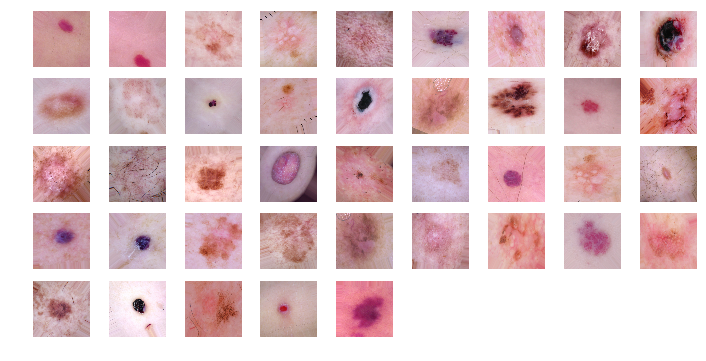

In [33]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [34]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [35]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 11809 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [36]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 15s 1us/step


In [37]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [38]:
type(mobile.layers)

list

In [39]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [56]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 2 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [57]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [58]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [59]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [60]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [61]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'bcc': 0, 'other': 1}


In [62]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 3.0, # akiec
    1: 1.0, # bcc
}

In [63]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 103.0 steps, validate for 8.0 steps
Epoch 1/30
102/103 [============================>.] - ETA: 1s - loss: 1.6265 - categorical_accuracy: 0.6069 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00001: val_top_3_accuracy improved from -inf to 1.00000, saving model to model.h5
103/103 [==============================] - 117s 1s/step - loss: 1.6229 - categorical_accuracy: 0.6068 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 6.0770 - val_categorical_accuracy: 0.6301 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 2/30
102/103 [============================>.] - ETA: 1s - loss: 0.9766 - categorical_accuracy: 0.7127 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00002: val_top_3_accuracy did not improve from 1.00000
103/103 [==============================] - 124s 1s/step - loss: 0.9723 - categorical_accuracy: 0.7126 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 4.2728 - va

In [64]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [65]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

  ...
    to  
  ['...']
val_loss: 0.8467991761816387
val_cat_acc: 0.6438356
val_top_2_acc: 1.0
val_top_3_acc: 1.0


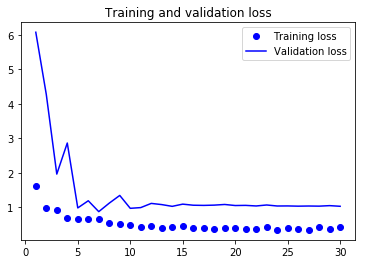

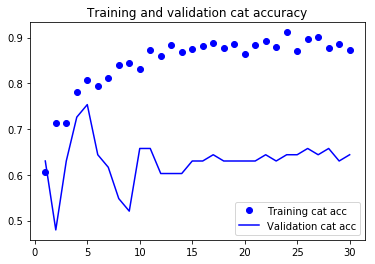

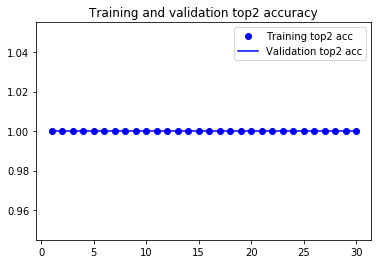

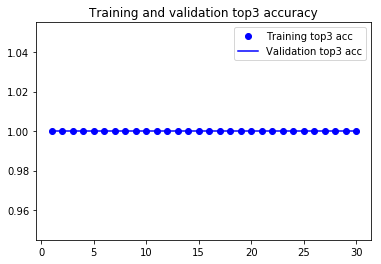

In [66]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [67]:
test_labels = test_batches.classes

In [68]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
73/73 [==============================] - 3s 35ms/step


In [69]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[28  2]
 [24 19]]


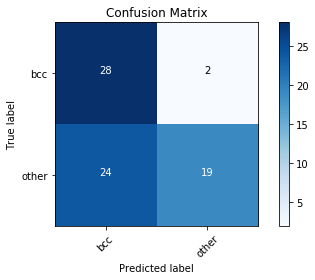

In [71]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['bcc',  'other']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [72]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [73]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

         bcc       0.54      0.93      0.68        30
       other       0.90      0.44      0.59        43

   micro avg       0.64      0.64      0.64        73
   macro avg       0.72      0.69      0.64        73
weighted avg       0.75      0.64      0.63        73

